In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score
from collections import deque

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 256

# Data

In [3]:
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

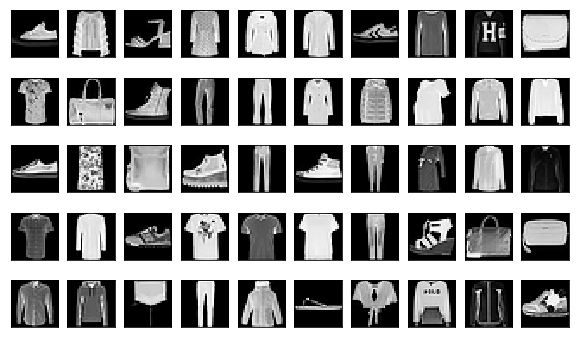

In [4]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channel:int=256):
        super(Discriminator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//4, kernel_size=6, stride=1, padding=2)
        self.conv2 = nn.Conv2d(channel//4, channel//3, kernel_size=5, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//3)
        self.conv3 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel//2)
        self.conv4 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv5 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x):
        h1: Variable = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2: Variable = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3: Variable = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4: Variable = F.leaky_relu(self.bn4(self.conv4(h3)), negative_slope=0.2)
        
        # Global Average Pooling
        h5 = F.leaky_relu(self.conv5(h4), negative_slope=0.2)
        gap = F.avg_pool2d(h5, kernel_size=h5.size()[2:]).view(h5.size()[0], -1)
        output = F.sigmoid(gap)
        return output
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator(
  (conv1): Conv2d (1, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d (64, 85, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (85, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d (256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, noise:int=100, channel:int=64):
        super(Generator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        _c = channel
        
        self.noise = noise
        self.tp_conv1 = nn.ConvTranspose2d(noise, _c*16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(_c*16)
        
        self.tp_conv2 = nn.ConvTranspose2d(_c*16, _c*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(_c*8)
        
        self.tp_conv3 = nn.ConvTranspose2d(_c*8, _c*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(_c*4)
        
        self.tp_conv4 = nn.ConvTranspose2d(_c*4, _c*2, kernel_size=4, stride=1, padding=2, bias=False)
        self.bn4 = nn.BatchNorm2d(_c*2)
        
        self.tp_conv5 = nn.ConvTranspose2d(_c*2, _c, kernel_size=4, stride=2, padding=2, bias=False)
        self.bn5 = nn.BatchNorm2d(_c)
        
        self.tp_conv6 = nn.ConvTranspose2d(_c, 1, kernel_size=5, stride=1, padding=2, bias=False)
    
    def forward(self, noise):
        h = self.tp_conv1(noise)
        h = F.relu(self.bn1(h))
#         print('h1', h.size())
        
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
#         print('h2', h.size())
        
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))
#         print('h3', h.size())
        
        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))
#         print('h4', h.size())
        
        h = self.tp_conv5(h)
        h = F.relu(self.bn5(h))
#         print('h5', h.size())
        
        h = self.tp_conv6(h)
        h = F.sigmoid(h)
#         print('h6', h.size())
        return h
    

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator(
  (tp_conv1): ConvTranspose2d (100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv2): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv4): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv5): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv6): ConvTranspose2d (64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)


# Train

In [7]:
N_EPOCH = 1000

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = deque(maxlen=100)
d_fake_losses = deque(maxlen=100)
d_losses = deque(maxlen=100)
g_losses = deque(maxlen=100)
divergences = deque(maxlen=100)

In [8]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        _batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((_batch_size, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_fake_pred = D(G(noise).detach())
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_pred = D(G(noise))
        g_loss = loss_f(y_pred, real_y[:_batch_size])
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences)),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses)), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses)),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses)), 
                  'G:{:<8.3}'.format(np.mean(g_losses)), end='')
    print()

[1/1000] divergence: 0.673    D: 0.493    D_real: 0.39     D_fake: 0.493    G:1.37    
[2/1000] divergence: 0.827    D: 0.251    D_real: 0.221    D_fake: 0.251    G:3.05    
[3/1000] divergence: 0.97     D: 0.037    D_real: 0.0463   D_fake: 0.037    G:5.0     
[4/1000] divergence: 0.998    D: 0.00235  D_real: 0.000478 D_fake: 0.00235  G:6.32    
[5/1000] divergence: 0.996    D: 0.0049   D_real: 0.00399  D_fake: 0.0049   G:6.91    
[6/1000] divergence: 0.932    D: 0.106    D_real: 0.136    D_fake: 0.106    G:5.03    
[7/1000] divergence: 0.866    D: 0.21     D_real: 0.245    D_fake: 0.21     G:3.16    
[8/1000] divergence: 0.871    D: 0.185    D_real: 0.21     D_fake: 0.185    G:3.19    
[9/1000] divergence: 0.876    D: 0.171    D_real: 0.187    D_fake: 0.171    G:3.11    
[10/1000] divergence: 0.899    D: 0.151    D_real: 0.133    D_fake: 0.151    G:3.39    
[11/1000] divergence: 0.893    D: 0.144    D_real: 0.155    D_fake: 0.144    G:3.23    
[12/1000] divergence: 0.899    D: 0.132  

[94/1000] divergence: 0.877    D: 0.2      D_real: 0.175    D_fake: 0.2      G:3.27    
[95/1000] divergence: 0.886    D: 0.186    D_real: 0.174    D_fake: 0.186    G:3.39    
[96/1000] divergence: 0.876    D: 0.197    D_real: 0.19     D_fake: 0.197    G:3.1     
[97/1000] divergence: 0.873    D: 0.195    D_real: 0.198    D_fake: 0.195    G:3.05    
[98/1000] divergence: 0.871    D: 0.201    D_real: 0.225    D_fake: 0.201    G:3.12    
[99/1000] divergence: 0.875    D: 0.188    D_real: 0.227    D_fake: 0.188    G:3.2     
[100/1000] divergence: 0.884    D: 0.174    D_real: 0.203    D_fake: 0.174    G:3.35    
[101/1000] divergence: 0.881    D: 0.179    D_real: 0.191    D_fake: 0.179    G:3.24    
[102/1000] divergence: 0.88     D: 0.195    D_real: 0.191    D_fake: 0.195    G:3.32    
[103/1000] divergence: 0.858    D: 0.252    D_real: 0.193    D_fake: 0.252    G:3.17    
[104/1000] divergence: 0.842    D: 0.27     D_real: 0.225    D_fake: 0.27     G:2.95    
[105/1000] divergence: 0.85

[186/1000] divergence: 0.829    D: 0.277    D_real: 0.303    D_fake: 0.277    G:2.83    
[187/1000] divergence: 0.814    D: 0.302    D_real: 0.286    D_fake: 0.302    G:2.62    
[188/1000] divergence: 0.813    D: 0.302    D_real: 0.255    D_fake: 0.302    G:2.54    
[189/1000] divergence: 0.819    D: 0.297    D_real: 0.264    D_fake: 0.297    G:2.52    
[190/1000] divergence: 0.821    D: 0.277    D_real: 0.3      D_fake: 0.277    G:2.32    
[191/1000] divergence: 0.83     D: 0.249    D_real: 0.301    D_fake: 0.249    G:2.52    
[192/1000] divergence: 0.836    D: 0.239    D_real: 0.287    D_fake: 0.239    G:2.65    
[193/1000] divergence: 0.834    D: 0.255    D_real: 0.289    D_fake: 0.255    G:2.64    
[194/1000] divergence: 0.838    D: 0.254    D_real: 0.292    D_fake: 0.254    G:2.67    
[195/1000] divergence: 0.839    D: 0.245    D_real: 0.246    D_fake: 0.245    G:2.64    
[196/1000] divergence: 0.842    D: 0.246    D_real: 0.228    D_fake: 0.246    G:2.65    
[197/1000] divergence

[278/1000] divergence: 0.874    D: 0.212    D_real: 0.196    D_fake: 0.212    G:2.74    
[279/1000] divergence: 0.861    D: 0.216    D_real: 0.189    D_fake: 0.216    G:2.73    
[280/1000] divergence: 0.857    D: 0.229    D_real: 0.236    D_fake: 0.229    G:2.85    
[281/1000] divergence: 0.867    D: 0.215    D_real: 0.219    D_fake: 0.215    G:2.85    
[282/1000] divergence: 0.871    D: 0.216    D_real: 0.184    D_fake: 0.216    G:3.02    
[283/1000] divergence: 0.877    D: 0.205    D_real: 0.198    D_fake: 0.205    G:3.08    
[284/1000] divergence: 0.873    D: 0.201    D_real: 0.222    D_fake: 0.201    G:2.92    
[285/1000] divergence: 0.871    D: 0.2      D_real: 0.252    D_fake: 0.2      G:2.9     
[286/1000] divergence: 0.866    D: 0.235    D_real: 0.242    D_fake: 0.235    G:2.94    
[287/1000] divergence: 0.87     D: 0.25     D_real: 0.232    D_fake: 0.25     G:2.89    
[288/1000] divergence: 0.87     D: 0.218    D_real: 0.249    D_fake: 0.218    G:2.74    
[289/1000] divergence

[370/1000] divergence: 0.917    D: 0.122    D_real: 0.148    D_fake: 0.122    G:3.18    
[371/1000] divergence: 0.912    D: 0.146    D_real: 0.15     D_fake: 0.146    G:3.35    
[372/1000] divergence: 0.915    D: 0.145    D_real: 0.189    D_fake: 0.145    G:3.5     
[373/1000] divergence: 0.921    D: 0.125    D_real: 0.175    D_fake: 0.125    G:3.41    
[374/1000] divergence: 0.923    D: 0.123    D_real: 0.128    D_fake: 0.123    G:3.51    
[375/1000] divergence: 0.916    D: 0.139    D_real: 0.185    D_fake: 0.139    G:3.47    
[376/1000] divergence: 0.911    D: 0.146    D_real: 0.19     D_fake: 0.146    G:3.57    
[377/1000] divergence: 0.913    D: 0.135    D_real: 0.158    D_fake: 0.135    G:3.48    
[378/1000] divergence: 0.92     D: 0.124    D_real: 0.17     D_fake: 0.124    G:3.52    
[379/1000] divergence: 0.929    D: 0.0998   D_real: 0.161    D_fake: 0.0998   G:3.67    
[380/1000] divergence: 0.925    D: 0.123    D_real: 0.161    D_fake: 0.123    G:3.7     
[381/1000] divergence

[462/1000] divergence: 0.933    D: 0.115    D_real: 0.104    D_fake: 0.115    G:4.08    
[463/1000] divergence: 0.94     D: 0.103    D_real: 0.0916   D_fake: 0.103    G:4.23    
[464/1000] divergence: 0.951    D: 0.0794   D_real: 0.062    D_fake: 0.0794   G:4.54    
[465/1000] divergence: 0.951    D: 0.074    D_real: 0.0485   D_fake: 0.074    G:4.45    
[466/1000] divergence: 0.95     D: 0.0788   D_real: 0.0582   D_fake: 0.0788   G:4.35    
[467/1000] divergence: 0.942    D: 0.0942   D_real: 0.0614   D_fake: 0.0942   G:4.33    
[468/1000] divergence: 0.938    D: 0.102    D_real: 0.068    D_fake: 0.102    G:4.12    
[469/1000] divergence: 0.934    D: 0.122    D_real: 0.146    D_fake: 0.122    G:4.12    
[470/1000] divergence: 0.931    D: 0.133    D_real: 0.155    D_fake: 0.133    G:4.17    
[471/1000] divergence: 0.939    D: 0.107    D_real: 0.0926   D_fake: 0.107    G:4.21    
[472/1000] divergence: 0.937    D: 0.115    D_real: 0.0984   D_fake: 0.115    G:4.22    
[473/1000] divergence

[554/1000] divergence: 0.957    D: 0.0732   D_real: 0.0855   D_fake: 0.0732   G:4.67    
[555/1000] divergence: 0.96     D: 0.0613   D_real: 0.0811   D_fake: 0.0613   G:4.58    
[556/1000] divergence: 0.965    D: 0.053    D_real: 0.0835   D_fake: 0.053    G:4.73    
[557/1000] divergence: 0.966    D: 0.0499   D_real: 0.084    D_fake: 0.0499   G:4.92    
[558/1000] divergence: 0.96     D: 0.0623   D_real: 0.105    D_fake: 0.0623   G:4.8     
[559/1000] divergence: 0.953    D: 0.0939   D_real: 0.109    D_fake: 0.0939   G:4.94    
[560/1000] divergence: 0.958    D: 0.0843   D_real: 0.0622   D_fake: 0.0843   G:4.97    
[561/1000] divergence: 0.959    D: 0.0793   D_real: 0.0624   D_fake: 0.0793   G:4.93    
[562/1000] divergence: 0.961    D: 0.0631   D_real: 0.0789   D_fake: 0.0631   G:4.87    
[563/1000] divergence: 0.962    D: 0.0609   D_real: 0.0764   D_fake: 0.0609   G:4.79    
[564/1000] divergence: 0.96     D: 0.0696   D_real: 0.0538   D_fake: 0.0696   G:4.77    
[565/1000] divergence

[646/1000] divergence: 0.956    D: 0.0944   D_real: 0.0725   D_fake: 0.0944   G:4.99    
[647/1000] divergence: 0.958    D: 0.0743   D_real: 0.0719   D_fake: 0.0743   G:5.16    
[648/1000] divergence: 0.959    D: 0.0681   D_real: 0.116    D_fake: 0.0681   G:5.33    
[649/1000] divergence: 0.961    D: 0.0634   D_real: 0.088    D_fake: 0.0634   G:5.23    
[650/1000] divergence: 0.96     D: 0.0788   D_real: 0.0443   D_fake: 0.0788   G:5.27    
[651/1000] divergence: 0.964    D: 0.0719   D_real: 0.0553   D_fake: 0.0719   G:5.13    
[652/1000] divergence: 0.968    D: 0.0581   D_real: 0.0474   D_fake: 0.0581   G:4.99    
[653/1000] divergence: 0.964    D: 0.0701   D_real: 0.0594   D_fake: 0.0701   G:5.21    
[654/1000] divergence: 0.967    D: 0.0658   D_real: 0.0602   D_fake: 0.0658   G:5.33    
[655/1000] divergence: 0.976    D: 0.0317   D_real: 0.0455   D_fake: 0.0317   G:5.28    
[656/1000] divergence: 0.971    D: 0.0464   D_real: 0.0549   D_fake: 0.0464   G:5.21    
[657/1000] divergence

[738/1000] divergence: 0.966    D: 0.0556   D_real: 0.0758   D_fake: 0.0556   G:5.28    
[739/1000] divergence: 0.962    D: 0.0722   D_real: 0.077    D_fake: 0.0722   G:5.41    
[740/1000] divergence: 0.969    D: 0.0566   D_real: 0.0768   D_fake: 0.0566   G:5.63    
[741/1000] divergence: 0.97     D: 0.0469   D_real: 0.0388   D_fake: 0.0469   G:5.52    
[742/1000] divergence: 0.969    D: 0.0487   D_real: 0.0533   D_fake: 0.0487   G:5.53    
[743/1000] divergence: 0.968    D: 0.0498   D_real: 0.0556   D_fake: 0.0498   G:5.52    
[744/1000] divergence: 0.969    D: 0.0452   D_real: 0.0554   D_fake: 0.0452   G:5.47    
[745/1000] divergence: 0.967    D: 0.0711   D_real: 0.0523   D_fake: 0.0711   G:5.8     
[746/1000] divergence: 0.963    D: 0.0801   D_real: 0.0368   D_fake: 0.0801   G:5.62    
[747/1000] divergence: 0.97     D: 0.0492   D_real: 0.0285   D_fake: 0.0492   G:5.53    
[748/1000] divergence: 0.97     D: 0.0587   D_real: 0.041    D_fake: 0.0587   G:5.84    
[749/1000] divergence

[830/1000] divergence: 0.971    D: 0.0476   D_real: 0.0992   D_fake: 0.0476   G:5.82    
[831/1000] divergence: 0.977    D: 0.0328   D_real: 0.1      D_fake: 0.0328   G:6.04    
[832/1000] divergence: 0.976    D: 0.0359   D_real: 0.0787   D_fake: 0.0359   G:5.83    
[833/1000] divergence: 0.973    D: 0.0568   D_real: 0.0375   D_fake: 0.0568   G:5.62    
[834/1000] divergence: 0.971    D: 0.0623   D_real: 0.0443   D_fake: 0.0623   G:5.81    
[835/1000] divergence: 0.974    D: 0.0423   D_real: 0.0367   D_fake: 0.0423   G:5.94    
[836/1000] divergence: 0.979    D: 0.0326   D_real: 0.0393   D_fake: 0.0326   G:5.72    
[837/1000] divergence: 0.984    D: 0.0223   D_real: 0.0645   D_fake: 0.0223   G:5.7     
[838/1000] divergence: 0.975    D: 0.0421   D_real: 0.0666   D_fake: 0.0421   G:6.01    
[839/1000] divergence: 0.966    D: 0.0581   D_real: 0.134    D_fake: 0.0581   G:5.97    
[840/1000] divergence: 0.965    D: 0.0643   D_real: 0.117    D_fake: 0.0643   G:5.64    
[841/1000] divergence

Process Process-901:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

## Save Model

In [ ]:
def save_moodel():
    check_point = {'G': G.state_dict(), 
                   'D': D.state_dict(), 
                   'divergence': divergences, 
                   'd_losses': d_losses, 
                   'g_losses': g_losses, 
                   'd_fake_losses': d_fake_losses, 
                   'd_real_losses': d_real_losses}
    torch.save(check_point, 'dcgan.pth.tar')

## Loss Visualization

In [ ]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

In [ ]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

## Generator Evaluation

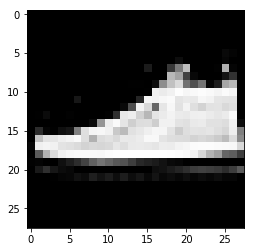

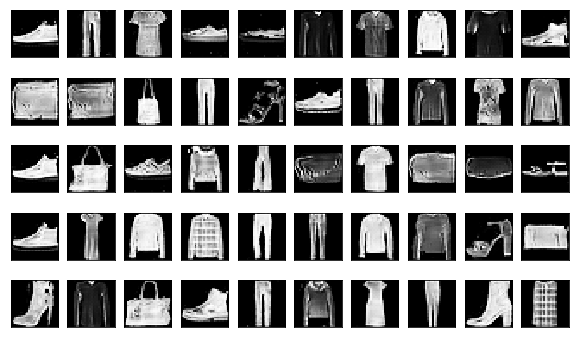

In [26]:
noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
images = 1-G(noise).view((-1, 28, 28)).data.cpu().numpy()

imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(5, 10) # subplots(y축, x축 갯수)
fig.set_figheight(6)
fig.set_figwidth(10)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1